# Решения уравнения фильтрации с учетом скин-фактора и послепритока

Материалы курсов "Исследования скважин и пластов" и "Гидродинамические исследования скважин" в РГУ нефти и газа имени И.М.Губкина.

Хабибуллин Ринат 2021 г.

версия 0.1 от 25.09.2021

## Скин-фактор

Скин-фактор — гидродинамический параметр скважины, характеризующий дополнительное фильтрационное сопротивление течению флюидов в призабойное зоне, приводящее к изменению добычи (дебита) по сравнению с совершенной (идеальной) скважиной. Скин фактор может приводить как к снижению дебита (например при загрязнении ПЗС), так и увеличению (образование высокопроводящих каналов в ПЗС).

Концепция скин-фактора получила широкое распространение на практике. Все инженеры-нефтяники знают этот параметр и оперируют им на практике.

Скин-фактор описывает изменение проницаемости призабойной зоны, которое может быть вызвано различными факторами, среди которых:
* Проникновение бурового раствора в призабойную зону при строительстве скважины
* Набухание глин при контакте с фильтратом бурового раствора при строительстве скважины
* Химическое осаждение нерастворимого осадка из фильтруемых флюидов в призабойной зоне, например отложение солей или асфальтенов при эксплуатации 
* Продвижение песчаных частиц к стволу скважины при эксплуатации
* Повреждение породы при перфорации при проведении текущего или капитального ремонта 
* и многими другими причинами

### Формула Хокинса - выражение скин фактора через радиус загрязненной зоны
Скин - фактор для плоскорадиального установившегося потока несжимаемой жидкости:

$$S =\left( \frac{k}{k_s} -1\right)\ ln\frac{r_s}{r_w}$$

* $k_s$ - проницаемость в загрязненной ПЗП
* $k$ - однородная проницаемость по всему пласту
* $r_s$ - радиус загрязненной зоны
* $r_w$ - радиус скважины

### Скин фактор в формуле Дюпюи (стационарное решение)


$$(p_e - p_{wf}) = \frac{18.41\mu q }{\ k h}(\ln\frac{r_e}{r_w}+S) $$

Продуктивность скважины определяется как:

$$J_{ss} = \frac{q_s}{p_e - p_{wf}} = \frac{k h}{18.41\mu B(\ ln\dfrac{r_e}{r_w} + S)} $$


### Скин фактор и нестационарное решение

$$ p(r, t) = p_{i} - \frac {9.205\mu {q_s} B }{k h}(\ ln\frac {k t}{ \phi \mu {c_t} {r^2}} +7.12 + 2S) $$

## Послеприток к скважине

In [2]:
!pip install mpmath

In [4]:
# импортируем библиотки, которые могут пригодиться для проведения расчетов
import numpy as np
import matplotlib.pyplot as plt
from mpmath import *
mp.dps = 15; mp.pretty = True

import scipy.special as sc

In [6]:
# решение линейного стока в пространстве Лапласа
def pd_lapl(s, rd=1):
  return 1/s * besselk(0, rd*s**0.5)

In [7]:
# пример расчета с использованием функции в пространстве Лапласа
print(pd_lapl(1, 1))

0.421024438240708


In [21]:
# реализация функции расчета безразмерного давления на основе преобразования Лапласа
def pd_line_source_lapl(rd, td):
  fp = lambda p: pd_lapl(p, rd)
  return invertlaplace(fp, td, method='stehfest', degree = 5)

pd_ls_func = np.vectorize(pd_line_source_lapl)

Построим решение учитывающее скин и послеприток

Решение для бесконечно малого радиуса скважины в пространстве Лапласа будет иметь вид

$$ \tilde{p}_D(s) = \frac{1}{s} K_0 \left( r_D \sqrt s  \right) $$

где 

$K_0$ - <a href="https://ru.wikipedia.org/wiki/%D0%9C%D0%BE%D0%B4%D0%B8%D1%84%D0%B8%D1%86%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%BD%D1%8B%D0%B5_%D1%84%D1%83%D0%BD%D0%BA%D1%86%D0%B8%D0%B8_%D0%91%D0%B5%D1%81%D1%81%D0%B5%D0%BB%D1%8F"
                        target="_blank" rel="noreferrer noopener">модифицированная функция Бесселя&nbsp;</a>
                        
Тогда решение с учетом скин-фактор и послепритока можно представить в виде

$$
\tilde{p}_{wbD}(s) = \frac{1}{s} \left[ \frac{S + s \tilde{p}_D(r_d=1,s) }{1 + s C_D (S + s \tilde{p}_D(r_d=1,s))} \right]
$$

In [9]:
# решение линейного стока в пространстве Лапласа
def pd_ws_lapl(s, S, Cd):
  return 1 / s * (S + s * pd_lapl(s)) / (1 + s * Cd * (S + s * pd_lapl(s)))

In [23]:
# реализация функции расчета безразмерного давления на основе преобразования Лапласа
def pd_wbs_lapl(rd, td, S =0 , Cd = 0):
  fp = lambda p: pd_ws_lapl(p, S, Cd)
  return invertlaplace(fp, td, method='stehfest', degree = 5)


pd_wbs_func = np.vectorize(pd_wbs_lapl)

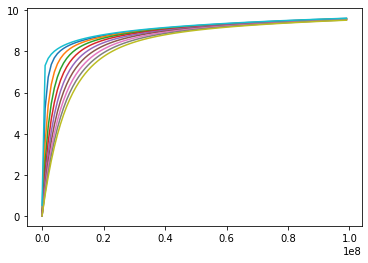

In [41]:
t_d = np.arange(1, 1e8, 1e6)
r_d = 1
S = 0
C_d = 100000 
p_d_1 = pd_ls_func(r_d, t_d)


fig, ax = plt.subplots(1,1)

clist = np.arange(1,10,1)
for ci in clist:
    p_d_2 = pd_wbs_func(r_d, t_d, S, ci*C_d)
    plt.plot(t_d, p_d_2)

#ax.set_xscale('log')
plt.plot(t_d, p_d_1)
plt.show()


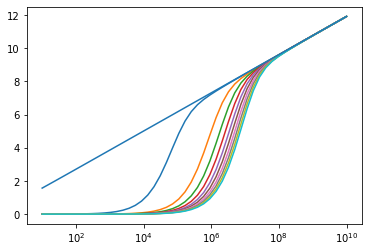

In [49]:
t_d = np.logspace(1, 10)
r_d = 1
S = 0
C_d = 10000 
p_d_1 = pd_ls_func(r_d, t_d)


fig, ax = plt.subplots(1,1)

clist = np.arange(1,100,10)
for ci in clist:
    p_d_2 = pd_wbs_func(r_d, t_d, S, ci*C_d)
    plt.plot(t_d, p_d_2)

ax.set_xscale('log')
plt.plot(t_d, p_d_1)
plt.show()


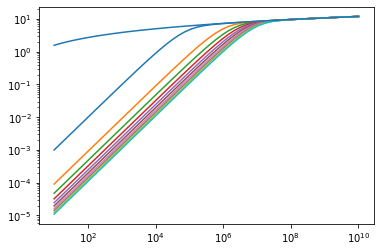

In [50]:
t_d = np.logspace(1, 10)
r_d = 1
S = 0
C_d = 10000 
p_d_1 = pd_ls_func(r_d, t_d)


fig, ax = plt.subplots(1,1)

clist = np.arange(1,100,10)
for ci in clist:
    p_d_2 = pd_wbs_func(r_d, t_d, S, ci*C_d)
    plt.plot(t_d, p_d_2)

ax.set_xscale('log')
ax.set_yscale('log')
plt.plot(t_d, p_d_1)
plt.show()

In [47]:
t_d = np.logspace(1, 10)
print(t_d)

[1.00000000e+01 1.52641797e+01 2.32995181e+01 3.55648031e+01
 5.42867544e+01 8.28642773e+01 1.26485522e+02 1.93069773e+02
 2.94705170e+02 4.49843267e+02 6.86648845e+02 1.04811313e+03
 1.59985872e+03 2.44205309e+03 3.72759372e+03 5.68986603e+03
 8.68511374e+03 1.32571137e+04 2.02358965e+04 3.08884360e+04
 4.71486636e+04 7.19685673e+04 1.09854114e+05 1.67683294e+05
 2.55954792e+05 3.90693994e+05 5.96362332e+05 9.10298178e+05
 1.38949549e+06 2.12095089e+06 3.23745754e+06 4.94171336e+06
 7.54312006e+06 1.15139540e+07 1.75751062e+07 2.68269580e+07
 4.09491506e+07 6.25055193e+07 9.54095476e+07 1.45634848e+08
 2.22299648e+08 3.39322177e+08 5.17947468e+08 7.90604321e+08
 1.20679264e+09 1.84206997e+09 2.81176870e+09 4.29193426e+09
 6.55128557e+09 1.00000000e+10]


In [14]:
t_d

array([1.0000000e+00, 1.0000001e+07, 2.0000001e+07, 3.0000001e+07,
       4.0000001e+07, 5.0000001e+07, 6.0000001e+07, 7.0000001e+07,
       8.0000001e+07, 9.0000001e+07])

In [15]:
p_d_1

[0.523149013519287,
 8.46431159973145,
 8.81033325195313,
 9.01289367675781,
 9.15694236755371,
 9.26873016357422,
 9.3600025177002,
 9.43709754943848,
 9.50393676757813,
 9.56283378601074]

In [18]:
pd_ls_func = np.vectorize(pd_line_source_lapl)

In [19]:
pd_ls_func(r_d, t_d)

array([0.523149013519287, 8.46431159973145, 8.81033325195313,
       9.01289367675781, 9.15694236755371, 9.26873016357422,
       9.3600025177002, 9.43709754943848, 9.50393676757813,
       9.56283378601074], dtype=object)

# Суперпозиция и решение для полубесконечной плоскости

расстояние от скважины до непротекаемой границы 100 м

In [51]:
rb = 100

используем `pd_ls_func`

In [69]:
r1 = 1
rw_m = 0.1
r2 = rb*2/rw_m

tlist = np.arange(1, 1e8, 1e5)

#pd1 = pd_ls_func(r1,tlist)
pd2 = pd_ls_func(r2,tlist)

S= 2
Cd = 1e5

pd1 = pd_wbs_func(r1,tlist, S, Cd)
#pd2 = pd_wbs_func(r2,tlist, S, Cd)


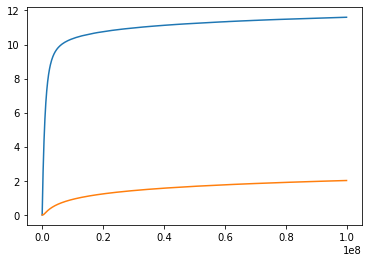

In [70]:

fig, ax = plt.subplots(1,1)
ax.plot(tlist, pd1)

ax.plot(tlist, pd2)
plt.show()

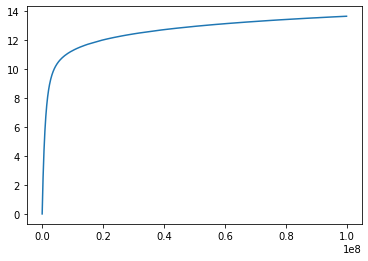

In [71]:
fig, ax = plt.subplots(1,1)
ax.plot(tlist, pd1+pd2)
plt.show()

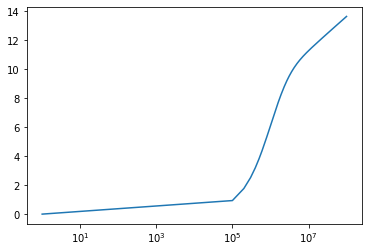

In [72]:
fig, ax = plt.subplots(1,1)
ax.plot(tlist, pd1+pd2)
ax.set_xscale('log')
plt.show()